In [1]:
# Dual Modeling (TSFEL All): Target (BUKA/TUTUP) & Nama (AZHARI/RIZAL)

# Notebook ini:
# 1. Memuat dataset: ./dataset/new/audio_features_all.csv
# 2. Melatih dua model terpisah (target & nama)
# 3. Menampilkan evaluasi dan confusion matrix
# 4. Menyimpan hasil model di ./models/*.joblib

import os, json
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

DATA_ALL_PATH = './dataset/new/audio_features_all.csv'
MODELS_DIR = './models'
REPORTS_DIR = './reports'
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)

RANDOM_STATE = 42
TEST_SIZE = 0.2


In [2]:
# Fungsi bantu
def load_dataset_all(path):
    df = pd.read_csv(path)
    for col in ['target','nama']:
        if col not in df.columns:
            raise ValueError(f"Kolom '{col}' tidak ditemukan di {path}.")
    drop_cols = [c for c in ['filename','sr','duration_sec','target','nama'] if c in df.columns]
    X_all = df.drop(columns=drop_cols, errors='ignore')
    X = X_all.select_dtypes(include=[np.number]).copy()
    feature_cols = list(X.columns)
    y_target = df['target'].astype(str).values
    y_name = df['nama'].astype(str).values
    return X, y_target, y_name, feature_cols


In [3]:
def get_models():
    return {
        'logreg': LogisticRegression(max_iter=300),
        'rf'    : RandomForestClassifier(n_estimators=250, random_state=RANDOM_STATE),
        'svc'   : SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE),
        'knn'   : KNeighborsClassifier(n_neighbors=5),
        'gb'    : GradientBoostingClassifier(random_state=RANDOM_STATE),
    }


In [4]:
def train_eval_models(X, y, label_name):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    results, fitted = [], {}
    for name, est in get_models().items():
        pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('clf', est)
        ])
        cv = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)
        cm = confusion_matrix(y_test, y_pred)
        results.append({
            'label': label_name, 'model': name,
            'test_accuracy': acc,
            'test_precision_weighted': prec,
            'test_recall_weighted': rec,
            'test_f1_weighted': f1,
            'cv_acc_mean_train': np.mean(cv),
            'cv_acc_std_train': np.std(cv)
        })
        fitted[name] = {'pipeline': pipe, 'cm': cm, 'y_test': y_test}
    best = max(results, key=lambda d: d['test_accuracy'])
    return pd.DataFrame(results), fitted, best['model'], fitted[best['model']]['pipeline'], fitted[best['model']]['cm'], fitted[best['model']]['y_test']


In [5]:
# Latih kedua model
X_all, y_target, y_name, feature_cols = load_dataset_all(DATA_ALL_PATH)

res_target, fitted_target, best_t_name, best_t_pipe, best_t_cm, y_t_test = train_eval_models(X_all, y_target, 'target')
res_name, fitted_name, best_n_name, best_n_pipe, best_n_cm, y_n_test = train_eval_models(X_all, y_name, 'nama')

comparison = pd.concat([res_target, res_name], ignore_index=True)
comparison.to_csv(f'{REPORTS_DIR}/dual_model_comparison.csv', index=False)
comparison


c:\Users\Ryzalll\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Ryzalll\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Ryzalll\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ryzalll\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close

,label,model,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,cv_acc_mean_train,cv_acc_std_train
0,target,logreg,0.988095,0.988372,0.988095,0.988094,0.963998,0.007166
1,target,rf,0.964286,0.966667,0.964286,0.964240,0.946043,0.024113
2,target,svc,0.964286,0.966667,0.964286,0.964240,0.949028,0.026234
3,target,knn,0.964286,0.966667,0.964286,0.964240,0.915920,0.033985
4,target,gb,0.952381,0.953409,0.952381,0.952354,0.946133,0.032029
5,nama,logreg,0.976190,0.977226,0.976190,0.976150,0.993985,0.007368
6,nama,rf,0.988095,0.988386,0.988095,0.988100,0.988014,0.011182
7,nama,svc,0.988095,0.988386,0.988095,0.988100,0.994030,0.007312
8,nama,knn,0.964286,0.966565,0.964286,0.964179,0.975984,0.015408
9,nama,gb,0.964286,0.964590,0.964286,0.964301,0.969923,0.016640


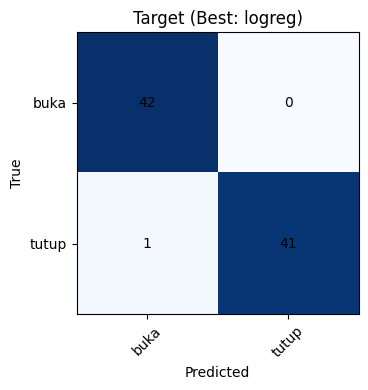

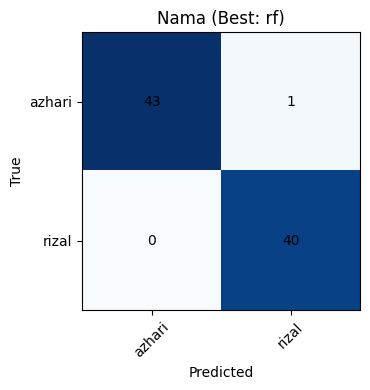

In [6]:
# Visualisasi confusion matrix
def plot_cm(cm, class_names, title):
    fig = plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    ticks = range(len(class_names))
    plt.xticks(ticks, class_names, rotation=45)
    plt.yticks(ticks, class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')
    plt.tight_layout()
    plt.show()

plot_cm(best_t_cm, sorted(list(set(y_t_test))), f'Target (Best: {best_t_name})')
plot_cm(best_n_cm, sorted(list(set(y_n_test))), f'Nama (Best: {best_n_name})')


In [7]:
# Simpan model terbaik ke ./models/
def dump_package(pipe, y, feature_cols, out_path):
    le = LabelEncoder()
    le.fit_transform(y)
    pkg = {
        'pipeline': pipe,
        'feature_columns': feature_cols,
        'label_encoder': le,
        'target_classes': list(le.classes_)
    }
    joblib.dump(pkg, out_path)
    print('Saved:', out_path)

dump_package(best_t_pipe, y_target, feature_cols, f'{MODELS_DIR}/model_all_features.joblib')
dump_package(best_n_pipe, y_name, feature_cols, f'{MODELS_DIR}/model_name_all_features.joblib')


Saved: ./models/model_all_features.joblib
Saved: ./models/model_name_all_features.joblib
